- what are the nearest neighbors of the additional graph structure induced by the adversary?

- Computing something like an "average" subgraph for a class might be difficult because it is unclear how we deal with conflicting directions on edge weights and how we actually average over all the possible subgraphs examples from various classes could elicit
    - But this analysis would be fairly interesting. Should think more about how to do this

In [1]:
import os
import parse

import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
import dionysus as dion
import numpy as np
from scipy.spatial.distance import hamming, cosine
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from pt_activation.models.cff import CFF

%load_ext autoreload
%autoreload 2

In [2]:
def get_adv_info(filename):
    format_string = 'true-{}_adv-{}_sample-{}.npy'
    parsed = parse.parse(format_string, filename)
    return {'true class':int(parsed[0]), 'adv class':int(parsed[1]), 'sample':int(parsed[2])}

def read_adversaries(loc):
    ret = []
    for f in os.listdir(loc):
        if os.path.isfile(os.path.join(loc,f)) and f.find('.npy') != -1:
            adv = np.load(os.path.join(loc, f))
            info = get_adv_info(f)
            info['adversary'] = adv
            ret.append(info)
    return ret
    

In [3]:
adv_directory_loc = '/home/tgebhart/projects/pt_activation/logdir/adversaries/mnist/projected_gradient_descent/cff_relu.pt'
adversaries = read_adversaries(adv_directory_loc)
adversaries = sorted(adversaries,  key=lambda k: k['sample'])

In [4]:
def create_filtrations(model, batch_size, up_to):
    device = torch.device("cpu")
    kwargs = {'num_workers': 0, 'pin_memory': False}
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
                           transforms.ToTensor(),
#                            transforms.Normalize((0.1307,), (0.3081,))
                       ])), batch_size=batch_size, shuffle=False, **kwargs)

    model.eval()
    test_loss = 0
    correct = 0
    t = 0
    res_df = []
    nms = []
    wms = []
    ims = np.empty((up_to, 28*28))
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, hiddens = model(data, hiddens=True)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            for s in range(data.shape[0]):
                # check if this makes sense
                this_hiddens = [hiddens[0][s], hiddens[1][s], hiddens[2][s]]
                print('Filtration: {}'.format(s+t))
                f, nm, wm = model.compute_dynamic_filtration2(data[s], this_hiddens, percentile=0, return_nm=True, absolute_value=True)
                row = {'filtration':f, 'loss':output.cpu().numpy()[s][0], 'class':target.cpu().numpy()[s], 'prediction':pred.cpu().numpy()[s][0]}
                res_df.append(row)
                nms.append(nm)
                wms.append(wm)
                ims[s+t,:] = data[s].numpy().reshape(28*28)

            t += batch_size
            if t >= up_to:
                break

    return pd.DataFrame(res_df), nms, wms, ims

def create_adversary_filtrations(model, batch_size, up_to, adversaries):
    device = torch.device("cpu")
    adv_images = torch.tensor(np.array([a['adversary'] for a in adversaries]))
    adv_labels = torch.tensor(np.array([a['true class'] for a in adversaries]))
    
    print(adv_images.shape)
    
    advs = torch.utils.data.TensorDataset(adv_images, adv_labels)
    test_loader = torch.utils.data.DataLoader(advs, batch_size=batch_size, shuffle=False)
    
    model.eval()
    test_loss = 0
    correct = 0
    t = 0
    res_df = []
    nms = []
    wms = []
    ims = np.empty((up_to, 28*28))
    with torch.no_grad():
        
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, hiddens = model(data, hiddens=True)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            for s in range(data.shape[0]):
                # check if this makes sense
                this_hiddens = [hiddens[0][s], hiddens[1][s], hiddens[2][s]]
                print('Filtration: {}'.format(s+t))
                f, nm, wm = model.compute_dynamic_filtration2(data[s], this_hiddens, percentile=0, return_nm=True, absolute_value=True)
                row = {'filtration':f, 'loss':output.cpu().numpy()[s][0], 'class':target.cpu().numpy()[s], 'prediction':pred.cpu().numpy()[s][0]}
                res_df.append(row)
                nms.append(nm)
                wms.append(wm)
                ims[s+t,:] = data[s].numpy().reshape(28*28)
            t += (batch_size)
            if t >= up_to:
                break

    return pd.DataFrame(res_df), nms, wms, ims

def get_adv_dist(i,j):
    return np.linalg.norm(i-j,2)


def create_moved_filtrations(model, ims, labels, devs, times=1, batch_size=10):
    device = torch.device("cpu")

    nims = []
    for i in range(len(ims)):
#         print('finding alteration number', i)
        im = ims[i]
        dev = devs[i]
        delim = np.zeros(im.shape, dtype=im.dtype)
        sigma = 0
        while np.linalg.norm(im+delim - im) < dev:
            sigma += 0.00001
            delim = np.random.normal(scale=sigma, size=im.shape)
        nims.append((im+delim).reshape(1,28,28))
    tims = torch.FloatTensor(nims)
    tlabels = torch.tensor(np.array(labels))
    dataset = torch.utils.data.TensorDataset(tims, tlabels)
    test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    model.eval()
    test_loss = 0
    correct = 0
    t = 0
    res_df = []
    nms = []
    wms = []
    new_ims = np.empty((len(ims), 28*28))
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, hiddens = model(data, hiddens=True)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            for s in range(data.shape[0]):
                # check if this makes sense
                this_hiddens = [hiddens[0][s], hiddens[1][s], hiddens[2][s]]
                print('Filtration: {}'.format(s+t))
                f, nm, wm = model.compute_dynamic_filtration2(data[s], this_hiddens, percentile=0, return_nm=True, absolute_value=True)
                row = {'filtration':f, 'loss':output.cpu().numpy()[s][0], 'class':target.cpu().numpy()[s], 'prediction':pred.cpu().numpy()[s][0]}
                res_df.append(row)
                nms.append(nm)
                wms.append(wm)
                new_ims[s+t,:] = data[s].numpy().reshape(28*28)

            t += batch_size
            
    return pd.DataFrame(res_df), nms, wms, new_ims

    

In [5]:
model_location = '/home/tgebhart/projects/pt_activation/logdir/models/mnist/cff_relu.pt'
model = CFF()
model.load_state_dict(torch.load(model_location))

In [6]:
res_df, nms, wms, ims = create_filtrations(model, 50, 100)

Filtration: 0
filtration size 52676
Filtration: 1
filtration size 69019
Filtration: 2
filtration size 35621
Filtration: 3
filtration size 76419
Filtration: 4
filtration size 63063
Filtration: 5
filtration size 38854
Filtration: 6
filtration size 63745
Filtration: 7
filtration size 54862
Filtration: 8
filtration size 75657
Filtration: 9
filtration size 66299
Filtration: 10
filtration size 81093
Filtration: 11
filtration size 77782
Filtration: 12
filtration size 56424
Filtration: 13
filtration size 74440
Filtration: 14
filtration size 39990
Filtration: 15
filtration size 77578
Filtration: 16
filtration size 65254
Filtration: 17
filtration size 57303
Filtration: 18
filtration size 85852
Filtration: 19
filtration size 54410
Filtration: 20
filtration size 59929
Filtration: 21
filtration size 58309
Filtration: 22
filtration size 67514
Filtration: 23
filtration size 66688
Filtration: 24
filtration size 57722
Filtration: 25
filtration size 96710
Filtration: 26
filtration size 48293
Filtration:

In [7]:
adv_df, adv_nms, adv_wms, adv_ims = create_adversary_filtrations(model, 50, 100, adversaries)

torch.Size([5000, 1, 28, 28])
Filtration: 0
filtration size 121587
Filtration: 1
filtration size 124729
Filtration: 2
filtration size 124118
Filtration: 3
filtration size 123692
Filtration: 4
filtration size 120303
Filtration: 5
filtration size 109502
Filtration: 6
filtration size 122306
Filtration: 7
filtration size 127587
Filtration: 8
filtration size 119820
Filtration: 9
filtration size 119719
Filtration: 10
filtration size 122049
Filtration: 11
filtration size 123128
Filtration: 12
filtration size 117366
Filtration: 13
filtration size 119375
Filtration: 14
filtration size 130875
Filtration: 15
filtration size 120521
Filtration: 16
filtration size 126838
Filtration: 17
filtration size 127145
Filtration: 18
filtration size 116147
Filtration: 19
filtration size 118994
Filtration: 20
filtration size 117572
Filtration: 21
filtration size 122158
Filtration: 22
filtration size 116308
Filtration: 23
filtration size 128684
Filtration: 24
filtration size 118896
Filtration: 25
filtration size

In [8]:
dists = np.array([get_adv_dist(ims[i], adv_ims[i]) for i in range(res_df.shape[0])])

In [9]:
moved_df, moved_nms, moved_wms, moved_ims = create_moved_filtrations(model, ims, res_df['class'], dists, times=1)

Filtration: 0
filtration size 89404
Filtration: 1
filtration size 96830
Filtration: 2
filtration size 82801
Filtration: 3
filtration size 104112
Filtration: 4
filtration size 98796
Filtration: 5
filtration size 82723
Filtration: 6
filtration size 89770
Filtration: 7
filtration size 83189
Filtration: 8
filtration size 99125
Filtration: 9
filtration size 93410
Filtration: 10
filtration size 102609
Filtration: 11
filtration size 107005
Filtration: 12
filtration size 95753
Filtration: 13
filtration size 99292
Filtration: 14
filtration size 91680
Filtration: 15
filtration size 97764
Filtration: 16
filtration size 104413
Filtration: 17
filtration size 91025
Filtration: 18
filtration size 106464
Filtration: 19
filtration size 92839
Filtration: 20
filtration size 96490
Filtration: 21
filtration size 98302
Filtration: 22
filtration size 92098
Filtration: 23
filtration size 103239
Filtration: 24
filtration size 93555
Filtration: 25
filtration size 110165
Filtration: 26
filtration size 88779
Filt

In [10]:
print('Moved Accuracy:', moved_df[moved_df['prediction'] == moved_df['class']].shape[0]/moved_df.shape[0])
print('Actual Accuracy:', res_df[res_df['prediction'] == res_df['class']].shape[0]/res_df.shape[0])

Moved Accuracy: 1.0
Actual Accuracy: 1.0


In [11]:
res_df.head()

,class,filtration,loss,prediction
0,7,"[(2430), (2447), (2430, 2447), (2439), (2445),...",-14.049807,7
1,2,"[(3123), (3140), (3123, 3140), (3138), (3123, ...",-15.757190,2
2,1,"[(1670), (1710), (1670, 1710), (1688), (1716),...",-9.077868,1
3,0,"[(3484), (3501), (3484, 3501), (3458), (3498),...",-0.000041,0
4,4,"[(2864), (2904), (2864, 2904), (2857), (2906),...",-10.368915,4


In [12]:
ids = [{v: k for k, v in nm.items()} for nm in nms]
adv_ids = [{v: k for k, v in nm.items()} for nm in adv_nms]
moved_ids = [{v: k for k, v in nm.items()} for nm in moved_nms]

In [13]:
def create_sample_graphs(res_df, ids, wms):
    sample_graphs = []
    dgms = []
    lifetimes = []
    for s in range(res_df.shape[0]):
        print(s)
        wm = wms[s]
        tnms = ids[s]
        subgraphs = {}
        f = res_df['filtration'].iloc[s]
        m = dion.homology_persistence(f)
        dgm = dion.init_diagrams(m,f)[0]
        dgms.append(dgm)
        for i,c in enumerate(m):
            if len(c) == 2:
                w = f[i].data
                if (tnms[f[c[0].index][0]],tnms[f[c[1].index][0]]) in wm:
                    w = wm[(tnms[f[c[0].index][0]],tnms[f[c[1].index][0]])]
                elif (tnms[f[c[1].index][0]],tnms[f[c[0].index][0]]) in wm:
                    w = wm[(tnms[f[c[1].index][0]],tnms[f[c[0].index][0]])]
#                 else:
#                     print((tnms[f[c[0].index][0]],tnms[f[c[1].index][0]]))
#                     raise Exception('NO WM!')
                if False: #tnms[f[c[0].index][0]] in subgraphs:
                    subgraphs[tnms[f[c[0].index][0]]].add_edge(tnms[f[c[0].index][0]],tnms[f[c[1].index][0]], weight=w)
                else:
                    eaten = False
                    for k, v in subgraphs.items():
                        if v.has_node(tnms[f[c[0].index][0]]):
                            if tnms[f[c[1].index][0]] in subgraphs:
                                v.add_node(tnms[f[c[1].index][0]])
#                                 subgraphs[k] = nx.union(v, subgraphs[tnms[f[c[1].index][0]]])
                            else:
                                v.add_edge(tnms[f[c[0].index][0]], tnms[f[c[1].index][0]], weight=w)
                            eaten = True
                            break
                    if not eaten:
                        g = nx.Graph()
                        g.add_edge(tnms[f[c[0].index][0]], tnms[f[c[1].index][0]], weight=w)
                        subgraphs[tnms[f[c[0].index][0]]] = g
                        
        sample_graphs.append(subgraphs)
        lifetimes.append(create_lifetimes(f, subgraphs,dgm,ids[s]))
    return sample_graphs, dgms, lifetimes

def create_lifetimes(f, subgraphs, dgm, ids):
    lifetimes = {}
    for pt in dgm:
        k = ids[f[pt.data][0]] 
        if k in subgraphs.keys():
            if pt.death < float('inf'):
                lifetimes[k] = pt.birth - pt.death
            else:
                lifetimes[k] = pt.birth
    return lifetimes


In [14]:
sample_graphs, dgms, lifetimes = create_sample_graphs(res_df, ids, wms)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [15]:
adv_sample_graphs, adv_dgms, adv_lifetimes = create_sample_graphs(adv_df, adv_ids, adv_wms)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [16]:
moved_sample_graphs, moved_dgms, moved_lifetimes = create_sample_graphs(moved_df, moved_ids, moved_wms)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [17]:
res_df.head(10)

,class,filtration,loss,prediction
0,7,"[(2430), (2447), (2430, 2447), (2439), (2445),...",-14.049807,7
1,2,"[(3123), (3140), (3123, 3140), (3138), (3123, ...",-15.757190,2
2,1,"[(1670), (1710), (1670, 1710), (1688), (1716),...",-9.077868,1
3,0,"[(3484), (3501), (3484, 3501), (3458), (3498),...",-0.000041,0
4,4,"[(2864), (2904), (2864, 2904), (2857), (2906),...",-10.368915,4
5,1,"[(1804), (1844), (1804, 1844), (1822), (1850),...",-12.010099,1
6,4,"[(2958), (3007), (2958, 3007), (2964), (3009),...",-20.694860,4
7,9,"[(2520), (2529), (2520, 2529), (2485), (2485, ...",-18.227373,9
8,5,"[(3436), (3444), (3436, 3444), (3440), (3436, ...",-15.517090,5
9,9,"[(3027), (3044), (3027, 3044), (3038), (3027, ...",-16.870689,9


In [18]:
goi = 1

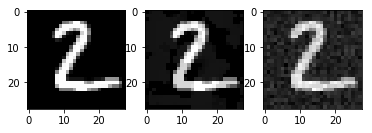

In [19]:
plt.subplot(131).imshow(ims[goi].reshape(28,28), cmap='gray')
plt.subplot(132).imshow(adv_ims[goi].reshape(28,28), cmap='gray')
plt.subplot(133).imshow(moved_ims[goi].reshape(28,28), cmap='gray')

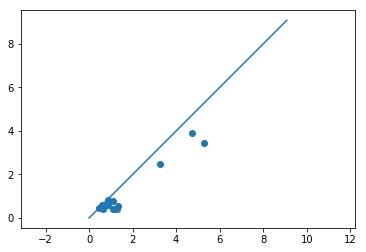

In [20]:
dion.plot.plot_diagram(dgms[goi])

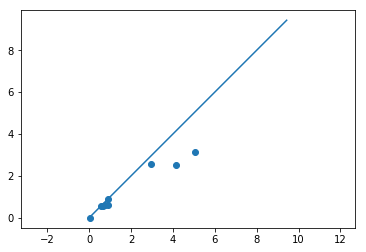

In [21]:
dion.plot.plot_diagram(adv_dgms[goi])

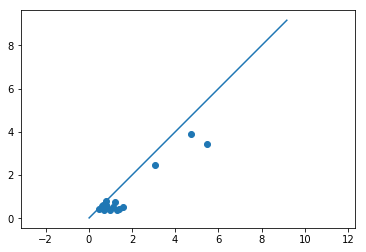

In [22]:
dion.plot.plot_diagram(moved_dgms[goi])

In [23]:
lifetimes[goi]

{(2, 0, 37): 9.084573745727539,
 (2, 0, 2): 1.8650362491607666,
 (2, 0, 13): 0.8276798725128174,
 (2, 0, 34): 0.8039424419403076,
 (2, 0, 20): 0.34826695919036865,
 (1, 0, 2508): 0.0297432541847229,
 (1, 0, 2438): 0.2470046877861023,
 (1, 0, 2745): 0.14679038524627686,
 (1, 0, 2485): 0.11969900131225586,
 (1, 0, 2719): 0.02935028076171875,
 (1, 0, 2649): 0.009134054183959961,
 (1, 0, 2779): 0.005280822515487671}

In [24]:
adv_lifetimes[goi]

{(2, 0, 37): 9.433835983276367,
 (2, 0, 2): 1.941847801208496,
 (2, 0, 34): 1.6161308288574219,
 (2, 0, 13): 0.41254401206970215,
 (1, 0, 2508): 0.03173685073852539,
 (1, 0, 2438): 0.255160391330719,
 (1, 0, 2485): 0.12317579984664917,
 (1, 0, 2745): 0.11920422315597534,
 (1, 0, 2719): 0.030927658081054688}

In [25]:
moved_lifetimes[goi]

{(2, 0, 37): 9.167183876037598,
 (2, 0, 2): 2.050084352493286,
 (2, 0, 13): 0.8271517753601074,
 (2, 0, 34): 0.5734696388244629,
 (2, 0, 20): 0.49042367935180664,
 (1, 0, 2508): 0.028458893299102783,
 (1, 0, 2438): 0.2345433235168457,
 (1, 0, 2745): 0.16311246156692505,
 (1, 0, 2485): 0.11612445116043091,
 (1, 0, 2719): 0.026337265968322754,
 (1, 0, 2649): 0.00923997163772583,
 (1, 0, 2802): 0.019382208585739136}

In [26]:
sgk = (2,0,37)
agk = (2,0,37)
mgk = sgk

/home/tgebhart/.local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


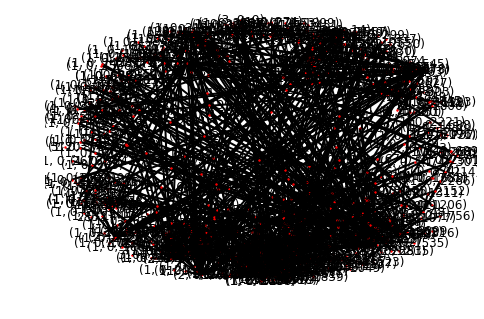

In [27]:
options = {
    'node_color': 'red',
    'node_size': 2,
    'width': 2,
    'with_labels':True}
nx.draw_spring(sample_graphs[goi][sgk], **options)

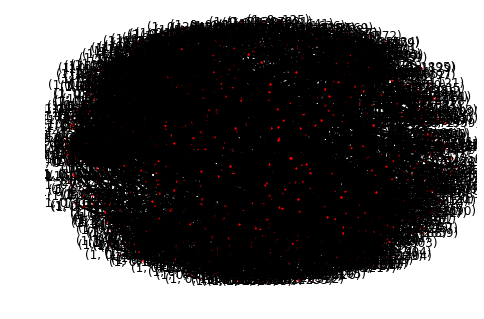

In [28]:
options = {
    'node_color': 'red',
    'node_size': 2,
    'width': 2,
    'with_labels':True}
nx.draw_spring(adv_sample_graphs[goi][agk], **options)

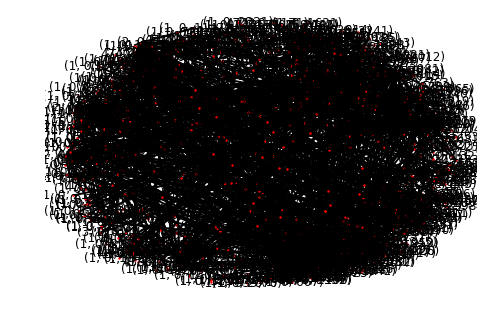

In [29]:
options = {
    'node_color': 'red',
    'node_size': 2,
    'width': 2,
    'with_labels':True}
nx.draw_spring(moved_sample_graphs[goi][mgk], **options)

In [30]:
def hamming_distance(g1, g2, ret_labels=False):
    nodeset = set(list(g1.nodes) + list(g2.nodes))
    g1_vec = np.zeros((len(nodeset)))
    g2_vec = np.zeros((len(nodeset)))
    nodesetlist = list(nodeset)
    for i in range(len(nodesetlist)):
        node = nodesetlist[i]
        if node in g1.nodes:
            g1_vec[i] = 1.0
        if node in g2.nodes:
            g2_vec[i] = 1.0
    if ret_labels:
        return hamming(g1_vec, g2_vec), nodesetlist
    else:
        return hamming(g1_vec, g2_vec)
    
def edge_hamming_distance(g1, g2, ret_labels=False):
    edgeset = set(list(g1.edges) + list(g2.edges))
    g1_vec = np.zeros((len(edgeset)))
    g2_vec = np.zeros((len(edgeset)))
    edgesetlist = list(edgeset)
    for i in range(len(edgesetlist)):
        edge = edgesetlist[i]
        if edge in g1.edges:
            g1_vec[i] = 1.0
        if edge in g2.edges:
            g2_vec[i] = 1.0
    if ret_labels:
        return hamming(g1_vec, g2_vec), edgesetlist
    else:
        return hamming(g1_vec, g2_vec)
    
def lifetime_weighted_edge_distance(subgraphs1,subgraphs2,lifetimes1,lifetimes2,ret_labels=False):
    edges1 = {}
    edges2 = {}
    sg1keys = list(subgraphs1.keys())
    sg2keys = list(subgraphs2.keys())
    lifetimes1 = list(lifetimes1.values())
    lifetimes2 = list(lifetimes2.values())
    ml1 = max(lifetimes1)
    ml2 = max(lifetimes2)
    for i in range(len(sg1keys)):
        g = subgraphs1[sg1keys[i]]
        for e in g.edges:
            edges1[e] = lifetimes1[i]/ml1
    for i in range(len(sg2keys)):
        g = subgraphs2[sg2keys[i]]
        for e in g.edges:
            edges2[e] = lifetimes2[i]/ml2
    edgeset = set(list(edges1.keys()) + list(edges2.keys()))
    g1_vec = np.zeros((len(edgeset)))
    g2_vec = np.zeros((len(edgeset)))
    edgesetlist = list(edgeset)
    for i in range(len(edgesetlist)):
        edge = edgesetlist[i]
        if edge in edges1:
            g1_vec[i] += edges1[edge]
        if edge in edges2:
            g2_vec[i] += edges2[edge]
    if ret_labels:
        return cosine(g1_vec, g2_vec), edgesetlist
    else:
        return cosine(g1_vec, g2_vec)
    
def weighted_edge_distance(g1, g2, ret_labels=False):
    edgeset = set(list(g1.edges) + list(g2.edges))
    g1_vec = np.zeros((len(edgeset)))
    g2_vec = np.zeros((len(edgeset)))
    edgesetlist = list(edgeset)
    for i in range(len(edgesetlist)):
        edge = edgesetlist[i]
        if edge in g1.edges:
            g1_vec[i] = g1[edge[0]][edge[1]]['weight']
        if edge in g2.edges:
            g2_vec[i] = g2[edge[0]][edge[1]]['weight']
    if ret_labels:
        return cosine(g1_vec, g2_vec), edgesetlist
    else:
        return cosine(g1_vec, g2_vec)
    
def total_edge_weights(graphs):
    emap = {}
    for g in graphs:
        for e in g.edges:
            if e in emap:
                emap[e] += g[e[0]][e[1]]['weight']
            else:
                emap[e] = g[e[0]][e[1]]['weight']
    return emap

def count_nodes(graphs):
    nmap = {}
    for g in graphs:
        for n in g.nodes:
            if n in nmap:
                nmap[n] += 1.0
            else:
                nm[2] = 1.0
    return nmap

In [31]:
1-weighted_edge_distance(sample_graphs[goi][sgk], adv_sample_graphs[goi][agk])

0.9564543054090492

In [32]:
1-weighted_edge_distance(sample_graphs[goi][sgk], moved_sample_graphs[goi][mgk])

0.9893635193142291

In [33]:
sorted_res_df = res_df.sort_values(by=['prediction'])
sorted_res_df.head()

,class,filtration,loss,prediction
3,0,"[(3484), (3501), (3484, 3501), (3458), (3498),...",-0.000041,0
28,0,"[(3487), (3504), (3487, 3504), (3502), (3487, ...",-0.000032,0
71,0,"[(3974), (4000), (3974, 4000), (3982), (3999),...",0.000000,0
69,0,"[(3583), (3609), (3583, 3609), (3604), (3583, ...",-0.000211,0
10,0,"[(3656), (3673), (3656, 3673), (3648), (3674),...",-0.000029,0


In [34]:
# comb_sim_mat = np.zeros((len(combs),len(adv_combs)))
# for i in range(len(combs)):
#     g = combs[i]
#     for j in range(len(adv_combs)):
#         ag = adv_combs[j]
#         comb_sim_mat[i,j] = 1 - weighted_edge_distance(g,ag)

# comb_sim_mat = np.zeros((len(sample_graphs), len(adv_sample_graphs)))
# for i in range(len(sample_graphs)):
#     for j in range(len(adv_sample_graphs)):
#         comb_sim_mat[i,j] = 1 - lifetime_weighted_edge_distance(sample_graphs[i],adv_sample_graphs[j],lifetimes[i],adv_lifetimes[j])

adv_sim_mat = np.zeros((len(sample_graphs), len(adv_sample_graphs)))
for i in range(len(sample_graphs)):
    for j in range(len(adv_sample_graphs)):
        adv_sim_mat[i,j] = 1 - lifetime_weighted_edge_distance(sample_graphs[i],adv_sample_graphs[j],lifetimes[i],adv_lifetimes[j])
        

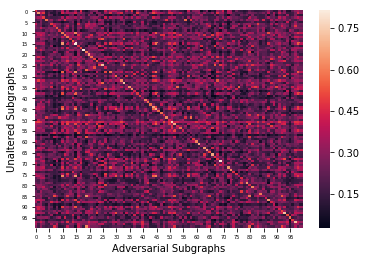

In [35]:
ax = sns.heatmap(adv_sim_mat, xticklabels=5, yticklabels=5)
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.tick_params(axis='y',labelsize=5)
plt.tick_params(axis='x',labelsize=5)
plt.ylabel('Unaltered Subgraphs')
plt.xlabel('Adversarial Subgraphs')
plt.savefig('/home/tgebhart/projects/pt_activation/logdir/vis/cff_mnist/adv_comb_heatmap.png', format='png', dpi=500)

In [36]:
moved_sim_mat = np.zeros((len(sample_graphs), len(moved_sample_graphs)))
for i in range(len(sample_graphs)):
    for j in range(len(moved_sample_graphs)):
        moved_sim_mat[i,j] = 1 - lifetime_weighted_edge_distance(sample_graphs[i],moved_sample_graphs[j],lifetimes[i],moved_lifetimes[j])
        

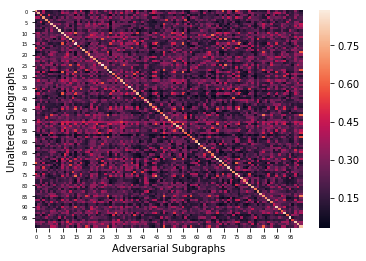

In [37]:
ax = sns.heatmap(moved_sim_mat, xticklabels=5, yticklabels=5)
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.tick_params(axis='y',labelsize=5)
plt.tick_params(axis='x',labelsize=5)
plt.ylabel('Unaltered Subgraphs')
plt.xlabel('Adversarial Subgraphs')
plt.savefig('/home/tgebhart/projects/pt_activation/logdir/vis/cff_mnist/moved_comb_heatmap.png', format='png', dpi=500)

In [38]:
moved_dists = np.array([get_adv_dist(ims[i], moved_ims[i]) for i in range(res_df.shape[0])])

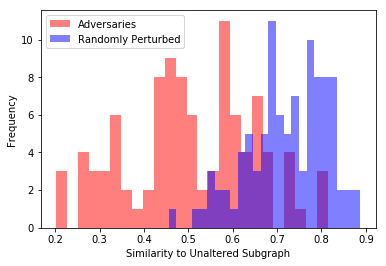

In [46]:
bins = 25
plt.hist(np.diagonal(adv_sim_mat), bins, alpha=0.5, label='Adversaries', color='r')
plt.hist(np.diagonal(moved_sim_mat), bins, alpha=0.5, label='Randomly Perturbed', color='b')
plt.xlabel('Similarity to Unaltered Subgraph')
plt.ylabel('Frequency')
plt.legend()

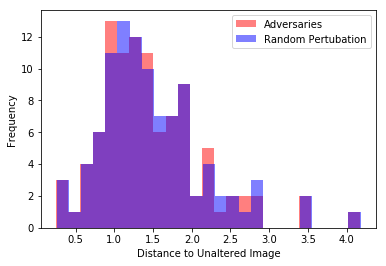

In [40]:
bins = 25
plt.hist(dists, bins, alpha=0.5, label='Adversaries', color='r')
plt.hist(moved_dists, bins, alpha=0.5, label='Random Pertubation', color='b')
plt.xlabel('Distance to Unaltered Image')
plt.ylabel('Frequency')
plt.legend()

In [41]:
def compute_num_generators(g):
    return len(g)
def compute_num_edges(g):
    num_edges = 0
    for sgk in g:
        num_edges += len(g[sgk].edges())
    return num_edges

In [42]:
num_generators = [compute_num_generators(g) for g in sample_graphs]
adv_num_generators = [compute_num_generators(g) for g in adv_sample_graphs]
moved_num_generators = [compute_num_generators(g) for g in moved_sample_graphs]

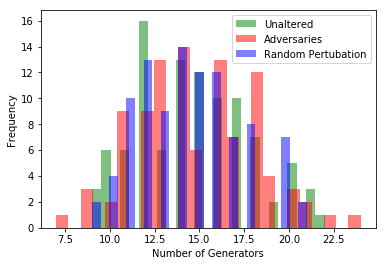

In [43]:
bins = 25
plt.hist(num_generators, bins, alpha=0.5, label='Unaltered', color='g')
plt.hist(adv_num_generators, bins, alpha=0.5, label='Adversaries', color='r')
plt.hist(moved_num_generators, bins, alpha=0.5, label='Random Pertubation', color='b')
plt.xlabel('Number of Generators')
plt.ylabel('Frequency')
plt.legend()

In [44]:
num_edges = [compute_num_edges(g) for g in sample_graphs]
adv_num_edges = [compute_num_edges(g) for g in adv_sample_graphs]
moved_num_edges = [compute_num_edges(g) for g in moved_sample_graphs]

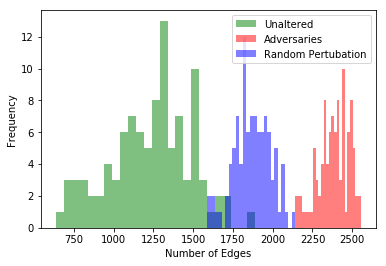

In [45]:
bins = 25
plt.hist(num_edges, bins, alpha=0.5, label='Unaltered', color='g')
plt.hist(adv_num_edges, bins, alpha=0.5, label='Adversaries', color='r')
plt.hist(moved_num_edges, bins, alpha=0.5, label='Random Pertubation', color='b')
plt.xlabel('Number of Edges')
plt.ylabel('Frequency')
plt.legend()

- Compute the set differences for each adversary and compare these set differences to each of the unaltered images like we did for the adv_sim_mat above. 
- Sort this similarity matrix by the _predicted_ class of the adversary. We would expect to see some sort of relationship emerge if these subgraphs were targeting class-specific information within the persistent subgraphs
- Compute these differences based on the composed graphs like in `lifetime_weighted_edge_distance()`

In [59]:
def set_difference(subgraphs1, subgraphs2):
    sg1keys = list(subgraphs1.keys())
    sg2keys = list(subgraphs2.keys())
    remove_edges = []
    edges2 = []
    for i in range(len(sg1keys)):
        g = subgraphs1[sg1keys[i]]
        remove_edges += list(g.edges)
    for i in range(len(sg2keys)):
        g = subgraphs2[sg2keys[i]]
        edges2 += list(g.edges)
    keep_edges = set(edges2).difference(set(remove_edges))
    ret_graph = nx.compose_all([subgraphs2[k] for k in sg2keys])
    rge = list(ret_graph.edges())
    ret_graph.remove_edges_from(e for e in rge if e not in keep_edges)
    return ret_graph

In [80]:
sorted_res_df = res_df.sort_values(by=['prediction'])
sorted_adv_df = adv_df.sort_values(by=['prediction'])

In [89]:
sorted_adv_df.head()

,class,filtration,loss,prediction
33,4,"[(5200), (5226), (5200, 5226), (5182), (5222),...",-0.790054,0
47,2,"[(5316), (5349), (5316, 5349), (5292), (5347),...",-7.763177,1
28,0,"[(5265), (5282), (5265, 5282), (5280), (5265, ...",-0.694306,2
3,0,"[(5255), (5272), (5255, 5272), (5270), (5255, ...",-0.700337,2
36,7,"[(5227), (5244), (5227, 5244), (5193), (5245),...",-7.487720,2


In [72]:
adv_differences = [set_difference(sample_graphs[i], adv_sample_graphs[i]) for i in range(len(sample_graphs))]

combs = []
for i in range(len(sample_graphs)):
    combs.append(nx.compose_all([sample_graphs[i][k] for k in sample_graphs[i]]))

In [73]:
diff_sim_mat = np.zeros((len(combs),len(adv_differences)))
for i in range(len(combs)):
    g = combs[i]
    for j in range(len(adv_differences)):
        ag = adv_differences[j]
        diff_sim_mat[i,j] = 1 - weighted_edge_distance(g,ag)

In [92]:
sorted_diff_sim_mat = np.empty(diff_sim_mat.shape)
sidxs = list(sorted_adv_df.index)
# aidxs = list(sorted_adv_df.index)
aidxs = sidxs
for i in range(len(sidxs)):
    for j in range(len(aidxs)):
        sorted_diff_sim_mat[i,j] = diff_sim_mat[sidxs[i],aidxs[j]]
        
sdsmdf = pd.DataFrame(sorted_diff_sim_mat, columns=sorted_adv_df['prediction'], index=sorted_res_df['prediction'])

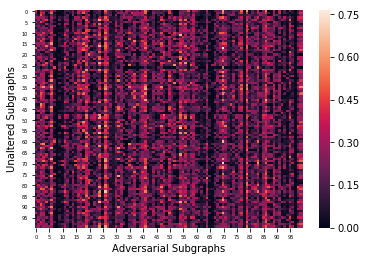

In [94]:
ax = sns.heatmap(diff_sim_mat, xticklabels=5, yticklabels=5)
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.tick_params(axis='y',labelsize=5)
plt.tick_params(axis='x',labelsize=5)
plt.ylabel('Unaltered Subgraphs')
plt.xlabel('Adversarial Subgraphs')
plt.savefig('/home/tgebhart/projects/pt_activation/logdir/vis/cff_mnist/adv_diff_heatmap.png', format='png', dpi=500)